# Pull Unemployment Data From FRED

In [1]:
%load_ext lab_black

In [285]:
import pandas as pd
from fredapi import Fred
import matplotlib.pylab as plt
import plotly.express as px
from tqdm import tqdm

plt.style.use("seaborn")

pd.set_option("max_columns", 500)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [207]:
from itertools import cycle
import seaborn as sns

# sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

## Setup FRED API

In [3]:
apifile = open("fred.api", "r")
fred = Fred(api_key=apifile.read())
apifile.close()

In [22]:
results = fred.search("State Unemployment Rate", limit=10_000)

# Pull Seasonally Adjusted State Unemployment Rate

In [66]:
sa_state = results.loc[
    (results["id"].str.endswith("UR")) & (results["seasonal_adjustment_short"] == "SA")
]
sa_state = sa_state.drop("DSUR")

In [49]:
myids = sa_state["id"].unique()

sa_ur = {}
for i in tqdm(myids):
    sa_ur[i] = fred.get_series(i)

100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:21<00:00,  2.45it/s]


In [125]:
sa_state.query('id == "DSUR"')["notes"].values

array([], dtype=object)

In [126]:
state_ur_sa_df = pd.DataFrame(sa_ur)

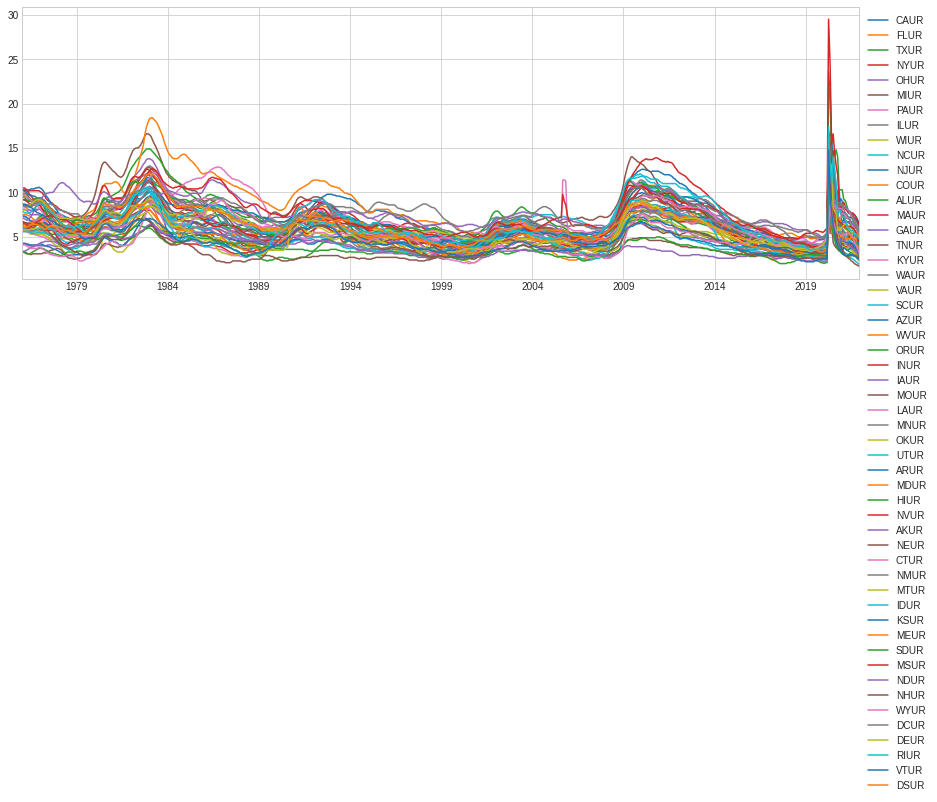

In [127]:
ax = state_ur_sa_df.plot(figsize=(15, 5))
ax.legend(bbox_to_anchor=(1, 1))

## Question
1. What State Had the highest unemployment rate post covid?!
2. When did it reach its height?

In [130]:
state_ur_sa_df = state_ur_sa_df.drop("DSUR", axis=1)

In [131]:
id_to_title = results["title"].to_dict()
state_ur_sa_df.columns = [id_to_title[c] for c in state_ur_sa_df.columns]
state_ur_sa_df.columns = [
    c.replace("Unemployment Rate in ", "") for c in state_ur_sa_df.columns
]

Text(0.5, 1.0, 'Top Unemployment Rate by State Post Covid')

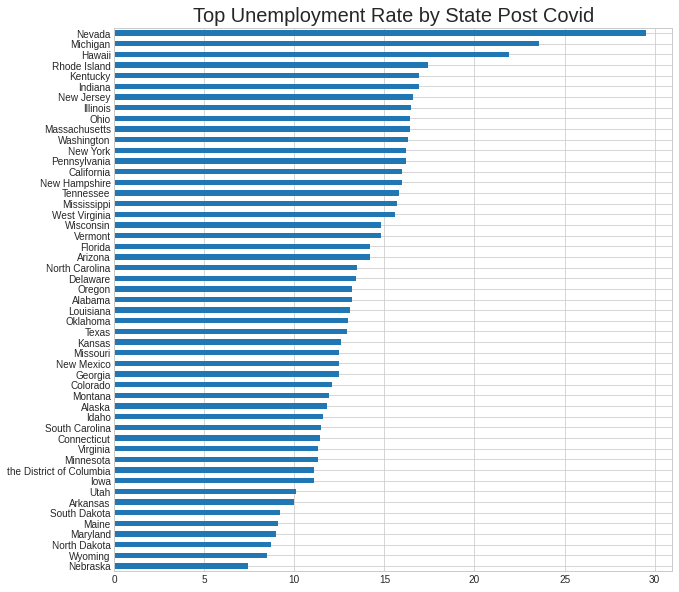

In [139]:
ax = (
    state_ur_sa_df.loc[state_ur_sa_df.index >= "2020-03-01"]
    .max()
    .sort_values(ascending=True)
    .plot(kind="barh", figsize=(10, 10))
)
ax.set_title("Top Unemployment Rate by State Post Covid", fontsize=20)

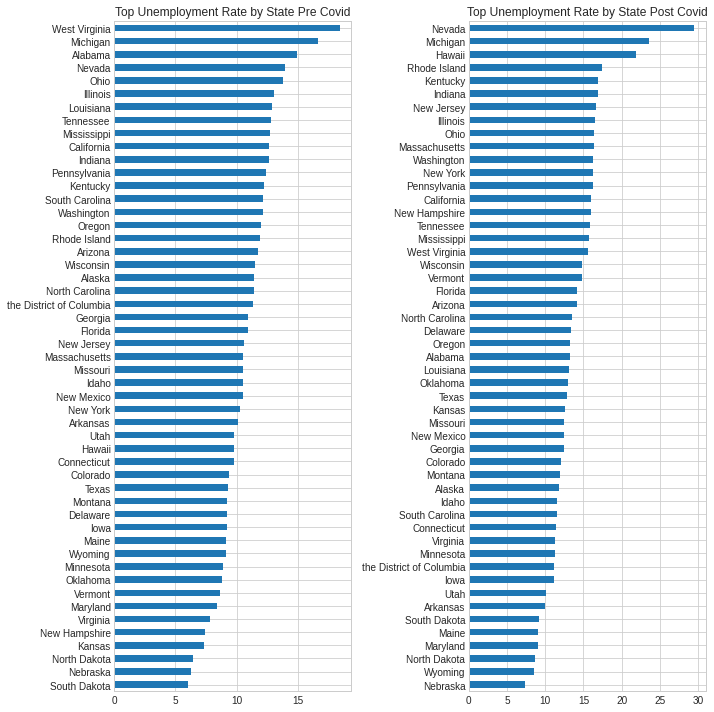

In [145]:
fig, axs = plt.subplots(1, 2, figsize=(10, 20))


state_ur_sa_df.loc[state_ur_sa_df.index <= "2020-03-01"].max().sort_values(
    ascending=True
).plot(kind="barh", figsize=(10, 10), ax=axs[0])
axs[0].set_title("Top Unemployment Rate by State Pre Covid", fontsize=12)

state_ur_sa_df.loc[state_ur_sa_df.index >= "2020-03-01"].max().sort_values(
    ascending=True
).plot(kind="barh", figsize=(10, 10), ax=axs[1])
axs[1].set_title("Top Unemployment Rate by State Post Covid", fontsize=12)
plt.tight_layout()
plt.show()

## Ratio Of Change Feb -> March 2020

In [158]:
state_df = state_ur_sa_df.T

In [159]:
state_df["feb_march_ratio"] = (
    state_ur_sa_df.loc[state_ur_sa_df.index == "2020-03-01"].T.values
    / state_ur_sa_df.loc[state_ur_sa_df.index >= "2020-02-01"].T.values
)

In [177]:
(
    state_ur_sa_df.loc[state_ur_sa_df.index == "2020-03-01"].T.values
    / state_ur_sa_df.loc[state_ur_sa_df.index >= "2020-02-01"].max().T.values
).shape

(51, 51)

In [178]:
# state_df["feb_to_post_covid_max_ratio"] = (
#     state_ur_sa_df.loc[state_ur_sa_df.index == "2020-03-01"].T.values
#     / state_ur_sa_df.loc[state_ur_sa_df.index >= "2020-02-01"].max().values
# )

# Small Multiples - Unemployment Jump Per State After Covid

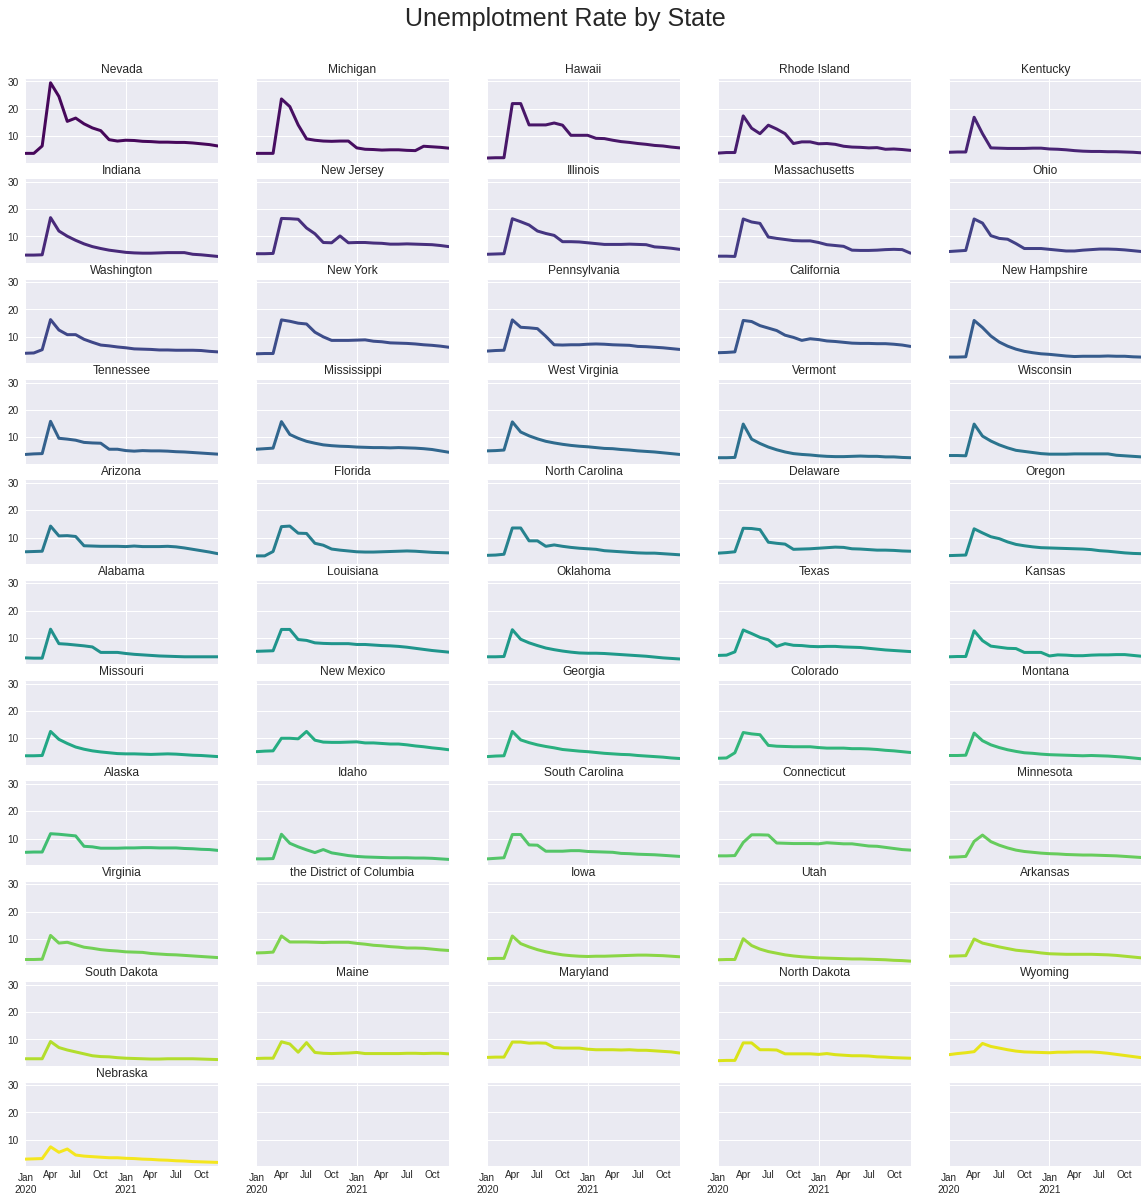

In [230]:
post_covid_ur = state_ur_sa_df.loc[state_ur_sa_df.index >= "2020-01-01"]

states_sorted = post_covid_ur.max().sort_values(ascending=False).index.tolist()
# Getting the color palette
mypal = sns.color_palette("viridis", n_colors=51)

fig, axs = plt.subplots(11, 5, figsize=(20, 20), sharex=True, sharey=True)
axs = axs.flatten()
for i, state in enumerate(states_sorted):
    post_covid_ur[state].plot(title=state, ax=axs[i], color=mypal[i], lw=3)
fig.suptitle("Unemplotment Rate by State", y=0.93, fontsize=25)
plt.show()

# Pull Covid Rate by State

In [273]:
# covid = pd.read_csv("covid_by_state.csv")

# covid["date"] = pd.to_datetime(covid["date"])
# covid["month"] = covid["date"].dt.month
# covid["year"] = covid["date"].dt.year
# covid["day"] = covid["date"].dt.day

# covid["case_daily"] = covid.sort_values("date").groupby("state")["cases"].diff()
# covid["deaths_daily"] = covid.sort_values("date").groupby("state")["deaths"].diff()

# covid["month_year"] = (
#     covid["year"].astype("str")
#     + "-"
#     + covid["month"].astype("str").str.zfill(2)
#     + "-01"
# )

# covid["month_year"] = pd.to_datetime(covid["month_year"]).dt.date
# covid.groupby(["month_year", "state"])["deaths_daily"].sum().unstack()

In [274]:
covid = pd.read_csv("United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv")

In [278]:
covid["submission_date"] = pd.to_datetime(covid["submission_date"])

In [295]:
covid["submission_date"].max()

Timestamp('2022-02-21 00:00:00')

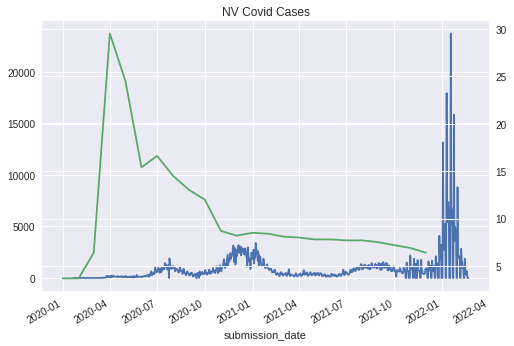

In [301]:
ax = (
    covid.query('state == "NV"')
    .set_index("submission_date")["new_case"]
    .plot(title="NV Covid Cases")
)

ax2 = ax.twinx()

ax2.plot(post_covid_ur["Nevada"], color=color_pal[1])
plt.show()

# Outliers

```
akshatluci: there are always and never outliers, it depends on how you look at the data. your view on this Rob?
```

In [306]:
import numpy as np

random_data = np.random.normal(20, size=5000)

<AxesSubplot:title={'center':'Distribution of Random Data'}, ylabel='Frequency'>

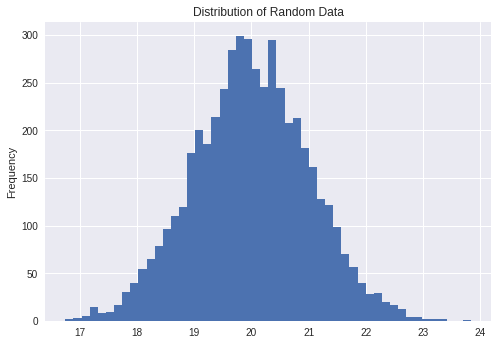

In [309]:
pd.Series(random_data).plot(kind="hist", bins=50, title="Distribution of Random Data")

In [313]:
mean = np.mean(random_data)
stdev = np.std(random_data)

In [315]:
print(f"Mean is {mean:0.2f} - StdDev {stdev:0.2f}")

Mean is 20.00 - StdDev 1.01


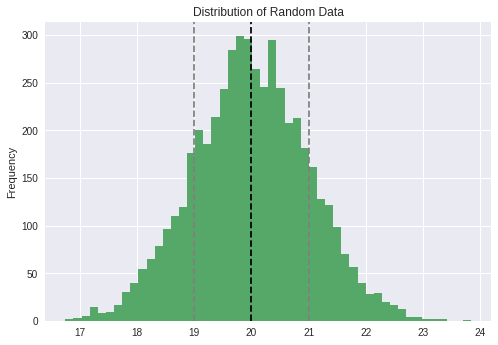

In [322]:
ax = pd.Series(random_data).plot(
    kind="hist", bins=50, title="Distribution of Random Data", color=color_pal[1]
)
ax.axvline(mean, color="black", ls="--")
ax.axvline(mean + stdev, color="grey", ls="--")
ax.axvline(mean - stdev, color="grey", ls="--")

In [328]:
((random_data > (mean - stdev)) & (random_data < (mean + stdev))).sum() / 5000

0.684

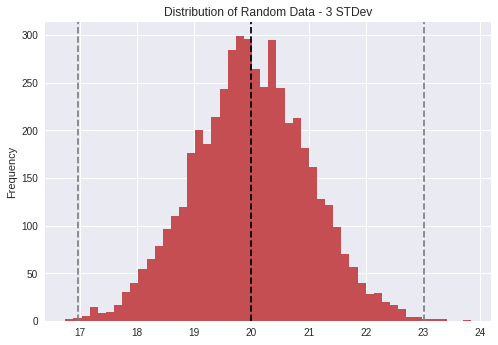

In [330]:
ax = pd.Series(random_data).plot(
    kind="hist",
    bins=50,
    title="Distribution of Random Data - 3 STDev",
    color=color_pal[2],
)
ax.axvline(mean, color="black", ls="--")
ax.axvline(mean + (3 * stdev), color="grey", ls="--")
ax.axvline(mean - (3 * stdev), color="grey", ls="--")

In [332]:
(
    (random_data > (mean - (3 * stdev))) & (random_data < (mean + (3 * stdev)))
).sum() / 5000

0.998

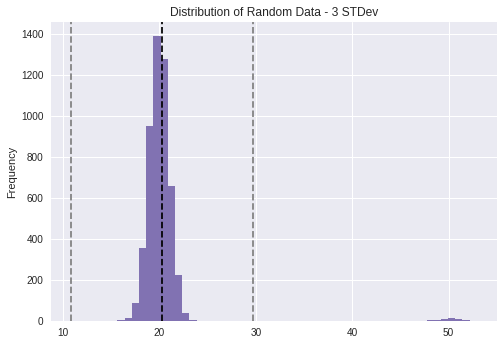

In [338]:
random_data = np.random.normal(20, size=5000)
random_data2 = np.random.normal(50, size=50)
all_rand_data = np.concatenate([random_data, random_data2])

mean = np.mean(all_rand_data)
stdev = np.std(all_rand_data)

ax = pd.Series(all_rand_data).plot(
    kind="hist",
    bins=50,
    title="Distribution of Random Data - 3 STDev",
    color=color_pal[3],
)
ax.axvline(mean, color="black", ls="--")
ax.axvline(mean + (3 * stdev), color="grey", ls="--")
ax.axvline(mean - (3 * stdev), color="grey", ls="--")

# Pull Unadjusted Unemployment Rate

In [88]:
na_state = results.loc[(results["id"].str.endswith("URN"))]
# na_state = na_state.drop("DSURA")

In [92]:
na_state

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
CAURN,CAURN,2022-02-22,2022-02-22,Unemployment Rate in California,1976-01-01,2021-12-01,Monthly,M,Percent,%,Not Seasonally Adjusted,NSA,2022-01-26 09:06:27-06:00,14,None
FLURN,FLURN,2022-02-22,2022-02-22,Unemployment Rate in Florida,1976-01-01,2021-12-01,Monthly,M,Percent,%,Not Seasonally Adjusted,NSA,2022-01-26 09:06:25-06:00,15,None
TXURN,TXURN,2022-02-22,2022-02-22,Unemployment Rate in Texas,1976-01-01,2021-12-01,Monthly,M,Percent,%,Not Seasonally Adjusted,NSA,2022-01-26 09:05:09-06:00,13,None
NYURN,NYURN,2022-02-22,2022-02-22,Unemployment Rate in New York,1976-01-01,2021-12-01,Monthly,M,Percent,%,Not Seasonally Adjusted,NSA,2022-01-26 09:06:35-06:00,6,None
MIURN,MIURN,2022-02-22,2022-02-22,Unemployment Rate in Michigan,1976-01-01,2021-12-01,Monthly,M,Percent,%,Not Seasonally Adjusted,NSA,2022-01-26 09:06:22-06:00,22,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GAQUIT9URN,GAQUIT9URN,2022-02-22,2022-02-22,"Unemployment Rate in Quitman County, GA",1990-01-01,2021-12-01,Monthly,M,Percent,%,Not Seasonally Adjusted,NSA,2022-02-02 10:34:21-06:00,1,These data come from the Current Population Su...
GAECHO1URN,GAECHO1URN,2022-02-22,2022-02-22,"Unemployment Rate in Echols County, GA",1990-01-01,2021-12-01,Monthly,M,Percent,%,Not Seasonally Adjusted,NSA,2022-02-02 10:34:38-06:00,1,These data come from the Current Population Su...
MOUN553URN,MOUN553URN,2022-02-22,2022-02-22,"Unemployment Rate in Mount Vernon-Anacortes, W...",1990-01-01,2021-12-01,Monthly,M,Percent,%,Not Seasonally Adjusted,NSA,2022-02-02 10:31:30-06:00,1,None


In [79]:
results.loc[results["title"].str.contains("California")]["title"]

series id
CAUR                                       Unemployment Rate in California
LAUST060000000000003A                      Unemployment Rate in California
CAURN                                      Unemployment Rate in California
U6UNEM6CA                Total Unemployed, Plus All Marginally Attached...
U4UNEM4CA                Total Unemployed Plus Discouraged Workers, as ...
CAINSUREDUR                        Insured Unemployment Rate in California
U3UNEM3CA                Total Unemployed, as a Percent of the Civilian...
CAOBEN                           State Unemployment Benefits in California
U1UNEM1CA                Persons Unemployed 15 Weeks or Longer, as a Pe...
U5UNEM5CA                Total Unemployed, Plus Discouraged Workers, Pl...
U2UNEM2CA                Job Losers and Persons Who Completed Temporary...
CAOTRA                   Transfers less State Unemployment Benefits in ...
LBSSA06                      Labor Force Participation Rate for California
LBSNSA06       